# Load data

In [27]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load packages
import pandas as pd


In [28]:
# Load taxi and weather data
taxi_weather_data_raw = pd.read_csv("data/taxi_weather_data_raw.csv")

# split train and test set

In [29]:
train_set, test_set = train_test_split(taxi_weather_data_raw, test_size=0.2, random_state=42)

In [30]:
taxi_weather_data = train_set.copy()

# Seek correlation

## correlation matrix (trip_dur and trip_dur_log)

In [31]:
corr_matrix = taxi_weather_data.select_dtypes(include='number').corr()

In [32]:
corr_matrix['trip_duration'].sort_values(ascending=False)

trip_duration         1.000000
trip_duration_min     1.000000
trip_duration_log     0.237362
hav_dist_km           0.087597
pickup_longitude      0.023529
vendor_id             0.018309
dropoff_longitude     0.012740
passenger_count       0.007458
temp_code             0.006753
pickup_month          0.006110
hour_of_year          0.006087
day_of_year           0.006068
temp_c                0.005917
hour_of_day           0.004537
pickup_hour_of_day    0.003735
windspeed_kph         0.001418
hazy_code             0.000741
windspeed_code        0.000721
rain_code             0.000616
daily_snow_mm         0.000222
pressure_hPa          0.000083
fog_code              0.000029
precip_mm            -0.000039
snow_code            -0.000171
pressure_code        -0.000720
freezing_code        -0.000772
cloud_code           -0.000931
pickup_day_of_week   -0.001056
precip_daily_mm      -0.002049
humidity_code        -0.003091
humidity             -0.003969
dropoff_latitude     -0.019364
pickup_l

- Not a strong predictor so far. Even distance is only weakly correlated
- No weather variable currently shows a significant linear correlation

In [33]:
corr_matrix['trip_duration_log'].sort_values(ascending=False)

trip_duration_log     1.000000
hav_dist_km           0.567280
trip_duration         0.237362
trip_duration_min     0.237362
pickup_longitude      0.103120
dropoff_longitude     0.066676
temp_c                0.059413
temp_code             0.056728
hour_of_year          0.047809
day_of_year           0.047608
pickup_month          0.046319
pickup_hour_of_day    0.038872
hour_of_day           0.038809
passenger_count       0.020860
vendor_id             0.019758
hazy_code             0.005002
rain_code             0.001106
cloud_code            0.000003
precip_mm            -0.000099
windspeed_kph        -0.000187
fog_code             -0.002719
freezing_code        -0.002752
daily_snow_mm        -0.003639
windspeed_code       -0.004039
snow_code            -0.008304
precip_daily_mm      -0.012524
pressure_hPa         -0.012646
pressure_code        -0.017744
humidity_code        -0.020818
humidity             -0.023740
pickup_day_of_week   -0.028519
dropoff_latitude     -0.122821
pickup_l

- The log transformation of trip_duration has reduced the dispersion
- haversine_km - Strong correlation: longer distance → longer duration (logarithmically smoothed)
- pickup_longitude - Possible district effect
- Weather characteristics hardly show linear effects, they could have a non-linear effect or only be relevant at certain times or locations
- Geographical coordinates contribute significantly

## Filter haversine in combination

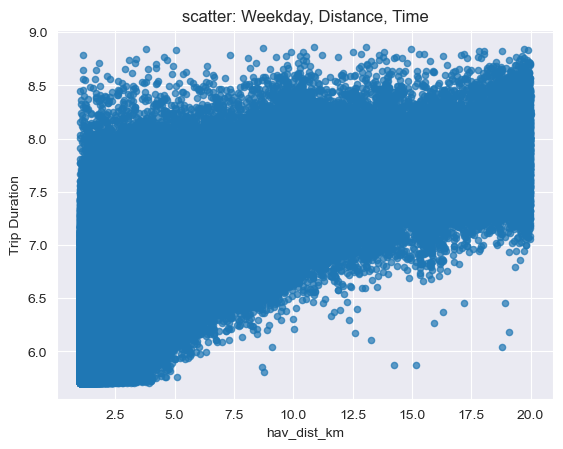

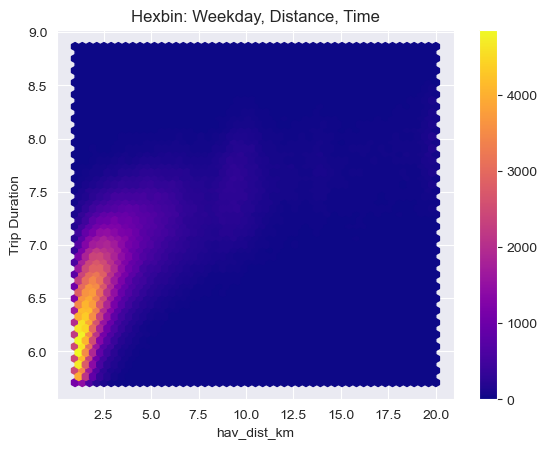

In [34]:
# Filter: ≤ 10 km, 7–9 AM, Monday to Friday (weekday 0–4)
filtered = taxi_weather_data[
(taxi_weather_data['trip_duration_min'].between(5, 120))  &# more than 5 minutes
(taxi_weather_data['hav_dist_km'].between(1, 20))&
(taxi_weather_data['pickup_hour_of_day'].between(5, 18)) &
(taxi_weather_data['pickup_day_of_week'].between(0, 6)) &
(taxi_weather_data['passenger_count'].between(1, 6)) &
(taxi_weather_data['pickup_longitude'].between(-74.3, -73.6)) &
(taxi_weather_data['dropoff_longitude'].between(-74.3, -73.6)) &
(taxi_weather_data['pickup_latitude'].between(40.47, 41.0)) &
(taxi_weather_data['dropoff_latitude'].between(40.47, 41.0))
  ]

filtered.plot.scatter(x="hav_dist_km", y="trip_duration_log", alpha=0.7, grid=True)
plt.xlabel("hav_dist_km")
plt.ylabel("Trip Duration")
plt.title("scatter: Weekday, Distance, Time")
plt.show()

filtered.plot.hexbin(
    x="hav_dist_km", y="trip_duration_log",
    gridsize=50, cmap='plasma'
)
plt.xlabel("hav_dist_km")
plt.ylabel("Trip Duration")
plt.title("Hexbin: Weekday, Distance, Time")
plt.grid(True)
plt.show()
# TODO: Add zone-based filtering (e.g. by longitude/latitude clusters or external zone map)

In [35]:
taxi_weather_data = train_set.drop("trip_duration_min", axis=1)
taxi_weather_labels = train_set["trip_duration_min"].copy()

# Imputation of  Features

In [36]:
taxi_weather_data.isna().sum()

id                        0
vendor_id                 0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
store_and_fwd_flag        0
trip_duration             0
pickup_hour_of_day        0
pickup_day_of_week        0
pickup_month              0
day_of_year               0
hour_of_year              0
hav_dist_km               0
trip_duration_log         0
datetime_hour         40266
humidity              40266
hour_of_day           40266
temp_c                40266
windspeed_kph         40266
precip_mm             40266
pressure_hPa          40266
precip_daily_mm       40266
daily_snow_mm         40266
rain_class            40266
rain_code             40266
snow_class            40266
snow_code             40266
cloud_class           40266
cloud_code            40266
hazy_class            40266
hazy_code             40266
freezing_class      

In [37]:
# Create new time column from hour_of_year (basis: start time)
base_time = pd.to_datetime("2016-01-01 00:00:00")
taxi_weather_data['datetime_hour_fallback'] = taxi_weather_data['hour_of_year'].apply(lambda h: base_time + pd.Timedelta(hours=h))

In [38]:
features_to_impute = [
  'humidity', 'windspeed_kph', 'temp_c','pressure_hPa', 'precip_daily_mm', 'daily_snow_mm',
  'precip_mm'
]

for feature in features_to_impute:
    print(f"\nImputing {feature}...")
    before = taxi_weather_data[feature]
    taxi_weather_data.set_index('datetime_hour_fallback', inplace=True)
    taxi_weather_data[feature] = taxi_weather_data[feature].interpolate(method='time')
    after = taxi_weather_data[feature]
    taxi_weather_data.reset_index(inplace=True)

    print("mean before:", before.mean())
    print("mean after:", after.mean())
    print("std deviation before:", before.std())
    print("std deviation after:", after.std())


Imputing humidity...
mean before: 52.027449986641805
mean after: 52.068176199878195
std deviation before: 18.887540998906797
std deviation after: 18.755000878484516

Imputing windspeed_kph...
mean before: 10.971251507144489
mean after: 10.9306083143484
std deviation before: 6.118355839214877
std deviation after: 6.0315310982474815

Imputing temp_c...
mean before: 10.988030137750673
mean after: 11.124590972915264
std deviation before: 9.172507864533003
std deviation after: 9.083095231736236

Imputing pressure_hPa...
mean before: 1015.77817598817
mean after: 1015.8423688638729
std deviation before: 7.958561824577401
std deviation after: 7.904491337775152

Imputing precip_daily_mm...
mean before: 2.205453014914139
mean after: 2.137015863194835
std deviation before: 6.428071126865827
std deviation after: 6.330183724486826

Imputing daily_snow_mm...
mean before: 1.58738194450978
mean after: 1.542200944427543
std deviation before: 23.814234713388917
std deviation after: 23.407941578262857



In [39]:
taxi_weather_data.isna().sum()

datetime_hour_fallback        0
id                            0
vendor_id                     0
pickup_datetime               0
dropoff_datetime              0
passenger_count               0
pickup_longitude              0
pickup_latitude               0
dropoff_longitude             0
dropoff_latitude              0
store_and_fwd_flag            0
trip_duration                 0
pickup_hour_of_day            0
pickup_day_of_week            0
pickup_month                  0
day_of_year                   0
hour_of_year                  0
hav_dist_km                   0
trip_duration_log             0
datetime_hour             40266
humidity                      0
hour_of_day               40266
temp_c                        0
windspeed_kph                 0
precip_mm                     0
pressure_hPa                  0
precip_daily_mm               0
daily_snow_mm                 0
rain_class                40266
rain_code                 40266
snow_class                40266
snow_cod

## Classify Weather Conditions

In [40]:
# 1. Human-readable rain classification
def classify_rain_label(x):
  if x >= 30:
    return 'extreme_rain'
  elif x >= 15:
    return 'very_heavy_rain'
  elif x >= 7.5:
    return 'heavy_rain'
  elif x >= 2.5:
    return 'moderate_rain'
  elif x > 0:
    return 'light_rain'
  else:
    return 'no_rain'

taxi_weather_data['rain_class'] = taxi_weather_data['precip_mm'].apply(classify_rain_label)

In [41]:
# 1. Human-readable temperature classification
def classify_temp_label(t):
  if t < -5:
    return 'very_cold'
  elif t < 5:
    return "cold"
  elif t < 15:
    return "cool"
  elif t < 20:
    return "mild"
  elif t < 25:
    return "warm"
  else:
    return "hot"


taxi_weather_data['temp_class'] = taxi_weather_data['temp_c'].apply(classify_temp_label)

In [42]:
# 1. Human-readable windspeed classification (Beaufort-based)
def classify_wind_label(speed):
  if speed < 1:
    return "calm"
  elif speed < 12:
    return 'light_air'
  elif speed < 29:
    return 'light_breeze'
  elif speed < 50:
    return 'moderate_breeze'
  elif speed < 75:
    return 'strong_breeze'
  else:
    return "stormy"


taxi_weather_data['windspeed_class'] = taxi_weather_data['windspeed_kph'].apply(classify_wind_label)

In [43]:
def classify_humidity(h):
  if h <= 30:
    return 'very_dry'
  elif h <= 50:
    return 'dry'
  elif h <= 70:
    return 'normal'
  elif h <= 85:
    return 'wet'
  else:
    return 'very_wet'


taxi_weather_data['humidity_class'] = taxi_weather_data['humidity'].apply(classify_humidity)

In [44]:
def classify_pressure_label(p):
  if p < 980:
    return 'very_low'
  elif p < 1000:
    return "low"
  elif p < 1020:
    return "normal"
  elif p < 1030:
    return "high"
  else:
    return 'very_high'


taxi_weather_data['pressure_class'] = taxi_weather_data['pressure_hPa'].apply(classify_pressure_label)

In [45]:
taxi_weather_data.isna().sum()

datetime_hour_fallback        0
id                            0
vendor_id                     0
pickup_datetime               0
dropoff_datetime              0
passenger_count               0
pickup_longitude              0
pickup_latitude               0
dropoff_longitude             0
dropoff_latitude              0
store_and_fwd_flag            0
trip_duration                 0
pickup_hour_of_day            0
pickup_day_of_week            0
pickup_month                  0
day_of_year                   0
hour_of_year                  0
hav_dist_km                   0
trip_duration_log             0
datetime_hour             40266
humidity                      0
hour_of_day               40266
temp_c                        0
windspeed_kph                 0
precip_mm                     0
pressure_hPa                  0
precip_daily_mm               0
daily_snow_mm                 0
rain_class                    0
rain_code                 40266
snow_class                40266
snow_cod